# Theory for the Net Ecosystem Respiration Model

In [93]:
#Load some modules etc
%matplotlib inline
import matplotlib.pyplot as plt
from sympy import *
import scipy as sc
import numpy as np
init_printing()

## The effect of daily temperature change on Net Ecosystem Respiration (NER) 


We would like to calculate the thermal response of the emergent ecosystem (NER) for a community of $a$ species. We start with the pure Boltzmann-Arrhenius version of the TPC equation for night-time autotroph respiration, which gives the NER model:
\begin{align}
	F_{a_d} &= x_0\sum_{i=1}^a R_{0,i} m_i^{p_x + p_R} e^{\frac{-E_{R,i}}{kT}}
\end{align}
Let us write this equation more simply as,
\begin{align}
	F_{a_d} = \sum_{i=1}^a R_{0,i}' e^{\frac{-E_{R,i}}{kT}}
\end{align}
where $R'_{0,i} = x_0 R_{0,i} m_i^{p_x + p_R}$

Let's analyze the two species case and generalize it to the $a$-species case

In [94]:
# Assign symbols
R_01, R_02, E1, E2, k, T, T_r, T_a, T_r_a = var('R_01 R_02 E1 E2 k T T_r T_a T_r_a')

# Assign functions
R1 = R_01 * exp(-(E1/k) * (1/T - 1/T_r))
R2 = R_02 * exp(-(E2/k) * (1/T - 1/T_r))

#define T_a = 1/kT , T_r_a = 1/kT_r

R_a1 = R_01 * exp(-E1 * (T_a - T_r_a))
R_a2 = R_02 * exp(-E2 * (T_a - T_r_a))

N = simplify(R1 + R2)
N_a = simplify(R_a1 + R_a2)
N_a

The following figure plots the Net Ecosystem Respiration (NER) model and its components:

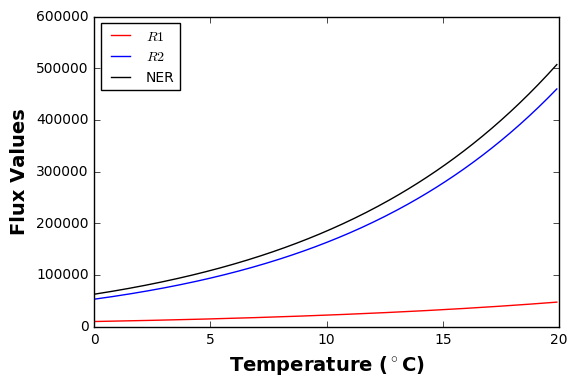

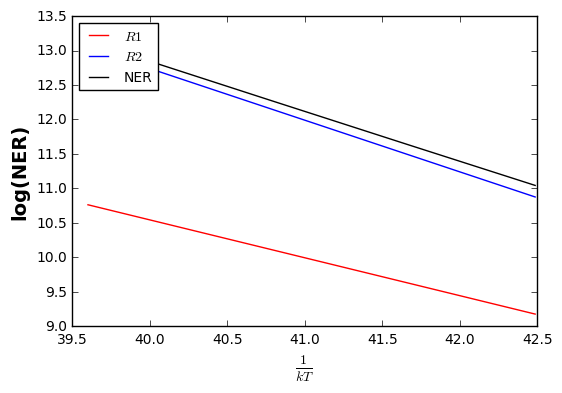

In [95]:
# Assign parameter values
k_par = 8.617 * 10**-5
E1_par = .55
E2_par = .75
T_r_par = 10+273.15
R_01_par = sc.exp(10)
R_02_par = sc.exp(12)

T_vec = 273.15+np.arange(0, 20, 0.1) #vector of temperatures

R1_lam = lambdify((R_01,E1,T_r,k,T), R1, np)
R1_vec = R1_lam(R_01_par,E1_par,T_r_par,k_par,T_vec)

R2_lam = lambdify((R_02,E2,T_r,k,T), R2, np)
R2_vec = R2_lam(R_02_par,E2_par,T_r_par,k_par,T_vec)

N_lam = lambdify((R_01,E1,R_02,E2,T_r,k,T), N, np)
N_vec = N_lam(R_01_par,E1_par,R_02_par,E2_par,T_r_par,k_par,T_vec)

fig = plt.figure(); ax = fig.add_subplot(111)
plt.hold(True)
ax.plot(T_vec-273.15, R1_vec,'red')
ax.plot(T_vec-273.15, R2_vec,'blue')
ax.plot(T_vec-273.15, N_vec,'black')
ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14, fontweight = 'bold')
ax.set_ylabel('Flux Values', fontsize=14, fontweight = 'bold')
plt.legend(['$R1$','$R2$', 'NER'], fontsize=10, loc='upper left')

#plt.savefig('../results/NER_Model.pdf')

fig = plt.figure(); ax = fig.add_subplot(111)
plt.hold(True)
ax.plot(1/(k_par*T_vec), sc.log(R1_vec),'red')
ax.plot(1/(k_par*T_vec), sc.log(R2_vec),'blue')
ax.plot(1/(k_par*T_vec), sc.log(N_vec),'black')
ax.set_xlabel(r'$\frac{1}{k T}$', fontsize=14, fontweight = 'bold')
ax.set_ylabel('log(NER)', fontsize=14, fontweight = 'bold')
plt.legend(['$R1$','$R2$', 'NER'], fontsize=10, loc='upper left')

We can now approximate the NER temperature response by a series expansion around the transformed variable $T_{ra}$:

In [96]:
N_appx = simplify(exp(series(ln(N_a),T_a,T_r_a,2).removeO()));simplify(N_appx)

Thus, substituting back $T_a = \frac{1}{k T}$ and $T_{ra} = \frac{1}{k T_r}$, taking logarithms, and some rearranging then shows that, the aproximation for the NER "activation energy" is:

$$E_\text{N} \approx  \frac{\sum_{i=1}^a R_{0,i} E_i }{\sum_{i=1}^a R_{0,i}} $$

Note that the accuracy of this approximation for NER depends on the reference temperature $T_r$. The approximation is good as long as $T_r$ lies within the OTR, and the best when $T_r$ is the mid-point of the OTR. The following figure shows how good the approximation is:

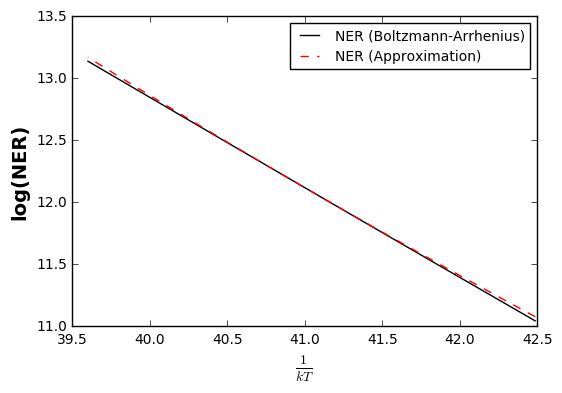

In [97]:
N_appx = simplify(exp(series(ln(N),T,T_r,2).removeO()))
N_appx_lam = lambdify((R_01,E1,R_02,E2,T_r,k,T), N_appx, np)
N_appx_vec = N_appx_lam(R_01_par,E1_par,R_02_par,E2_par,T_r_par,k_par,T_vec)

fig = plt.figure(); ax = fig.add_subplot(111)
plt.hold(True)
ax.plot(1/(k_par* T_vec), sc.log(N_vec.astype(float)),'black')
ax.plot(1/(k_par* T_vec), sc.log(N_appx_vec.astype(float)),'r--')

ax.set_xlabel(r'$\frac{1}{kT}$', fontsize=14, fontweight = 'bold')
ax.set_ylabel('log(NER)', fontsize=14, fontweight = 'bold')
plt.legend(['NER (Boltzmann-Arrhenius)', 'NER (Approximation)'], fontsize=10, loc='upper right')

In [98]:
E_N_appx = (E1 * R_01 + E2 * R_02)/((R_01+R_02))

import statsmodels.formula.api as sm
import pandas as pd

df = pd.DataFrame({"kT": 1/(k_par * T_vec), "NER": sc.log(N_vec), "NER_appx": sc.log(N_appx_vec)})

result2 = sm.ols(formula="NER_appx ~ kT", data=df).fit()
print ("Approx E_N :" + str(-result2.params[1]))
print ("Exact  E_N :" + str(E_N_appx.evalf(subs = {R_01:R_01_par,E1:E1_par,R_02:R_02_par,E2:E2_par,T_r:T_r_par,k:k_par})))

Approx E_N :0.725118021667
Exact  E_N :0.726159415595577
